# Capstone Sprint 1
**Author**: Eileen Cai  
**Contact**: eileen.ch.cai@gmail.com  
**Date**: Feb 22, 2024

## Introduction
We are going to identify harmful contents on social media by performing natural language processing (NLP) to encode text data into a numeric matrix then feed the numeric data into a machine learning model for sentiment analysis.

## Table of contents
[Exploratory Data Analysis](#eda)
- [Data Dictionary](#dict)
- [Loading data & checking high-level details](#data)
- [Text Processing](#text)
- [Vectorization](#vect)

[Fitting a Classifier](#classifier)

[Conclusion](#con)

In [2]:
# Import relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Data Dictionary <a class="anchor" id="dict"></a>  
<table align="left">
  <tr>
    <th style="text-align:left;">Column</th>
    <th style="text-align:left;">Data Type</th>
    <th style="text-align:left;">Description</th>
  </tr>
  <tr>
    <td style="text-align:left;">count</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The total number of annotations for each tweet.</td>
  </tr>
  <tr>
    <td style="text-align:left;">hate_speech_count</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The number of annotations classifying a tweet as hate speech.</td>
  </tr>
  <tr>
    <td style="text-align:left;">offensive_language_count</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The number of annotations classifying a tweet as offensive language.</td>
  </tr>
  <tr>
    <td style="text-align:left;">neither_count</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The number of annotations classifying a tweet as neither hate speech nor offensive language.</td>
  </tr>
  <tr>
    <td style="text-align:left;">class</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The category in which a tweet belongs to.</td>
  </tr>
  <tr>
    <td style="text-align:left;">tweet</td>
    <td style="text-align:left;">str</td>
    <td style="text-align:left;">The atual text of the tweet.</td>
  </tr>
</table>

### Loading data & checking high-level details <a class="anchor" id="data"></a>

In [10]:
# Loading the data

data = pd.read_csv('data/train.csv')

In [11]:
# View the data head

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Let's visualize some of the data to get an idea of what we are working with.

In [12]:
# Quickly check the data types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [13]:
# Take a look at the shape of dataset

print(f'There are {data.shape[0]} rows and {data.shape[1]} columns in the dataset.')

There are 24783 rows and 6 columns in the dataset.


In [14]:
# Checking for nulls

data.isna().sum().any()

False

In [15]:
# Checking for duplicates

print(f'Duplicated columns: {data.T.duplicated().any()}')
print(f'Duplicated rows: {data.duplicated().any()}')

Duplicated columns: False
Duplicated rows: False


In [16]:
# Summary statistics

data.describe().T

,count,mean,std,min,25%,50%,75%,max
count,24783.0,3.243473,0.883060,3.0,3.0,3.0,3.0,9.0
hate_speech_count,24783.0,0.280515,0.631851,0.0,0.0,0.0,0.0,7.0
offensive_language_count,24783.0,2.413711,1.399459,0.0,2.0,3.0,3.0,9.0
neither_count,24783.0,0.549247,1.113299,0.0,0.0,0.0,0.0,9.0
class,24783.0,1.110277,0.462089,0.0,1.0,1.0,1.0,2.0


The tweets are being classified into three classes, 0 being "hate speech", 1 being "offensive language" and 2 being "neither". Let's take a look at some sample data to see tweets and their associated classes.

In [17]:
print(data[['tweet', 'class']].sample(4).values)

[['@britty_jurgens a music suggestion is "lil spook"' 2]
 ["Quit talking shit you fucking faggot. You're seriously just mad bc no one wants you. Who the fuck do you even think you are?"
  1]
 ['Jax a hoe!' 1]
 ["it's awesome when people you've known for years talk trash about you behind your back and then ask you for favors later. truly awesome."
  2]]


Let's look at the distribution of classes:

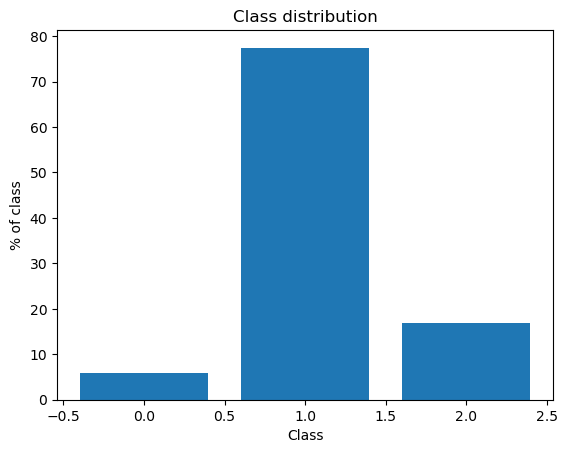

In [19]:
values, counts = np.unique(data['class'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Class')
plt.ylabel('% of class')
plt.title('Class distribution')
plt.show()

### Text Processing <a class="anchor" id="text"></a>

Let's remove stop words.

In [121]:
import nltk
from nltk.corpus import stopwords

bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(data['tweet'])

CountVectorizer(stop_words='english')

Let's tokenize our tweets.

In [129]:
data['tweet'].str.split(' ')

0        [!!!, RT, @mayasolovely:, As, a, woman, you, s...
1        [!!!!!, RT, @mleew17:, boy, dats, cold...tyga,...
2        [!!!!!!!, RT, @UrKindOfBrand, Dawg!!!!, RT, @8...
3        [!!!!!!!!!, RT, @C_G_Anderson:, @viva_based, s...
4        [!!!!!!!!!!!!!, RT, @ShenikaRoberts:, The, shi...
                               ...                        
24778    [you's, a, muthaf***in, lie, &#8220;@LifeAsKin...
24779    [you've, gone, and, broke, the, wrong, heart, ...
24780    [young, buck, wanna, eat!!.., dat, nigguh, lik...
24781        [youu, got, wild, bitches, tellin, you, lies]
24782    [~~Ruffled, |, Ntac, Eileen, Dahlia, -, Beauti...
Name: tweet, Length: 24783, dtype: object

### Vectorization <a class="anchor" id="vect"></a>

After performing TF-IDF and bag of words vectorization, I discovered that bag of words gave me higher accuracy scores on both training and testing datasets. Therefore, I will choose to use bag of words as my vectorization method.

In [130]:
from sklearn.feature_extraction.text import CountVectorizer

Let's split our data into train and test sets.

In [131]:
X = data['tweet']
y = data['class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Let's transform our training and test data into document-term matrices.

In [132]:
# 1. Instantiate 
bagofwords = CountVectorizer()

# 2. Fit 
bagofwords.fit(data["tweet"])

# 3. Transform 
X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

print(f'There are {X_train_transformed.shape[0]} rows and {X_train_transformed.shape[1]} columns in our training dataset.')
print(f'There are {X_test_transformed.shape[0]} rows and {X_test_transformed.shape[1]} columns in our testing dataset.')

There are 16604 rows and 35852 columns in our training dataset.
There are 8179 rows and 35852 columns in our testing dataset.


**Looking at frequent tokens**  

Let's look at the top 20 words and visualize the distribution of counts:

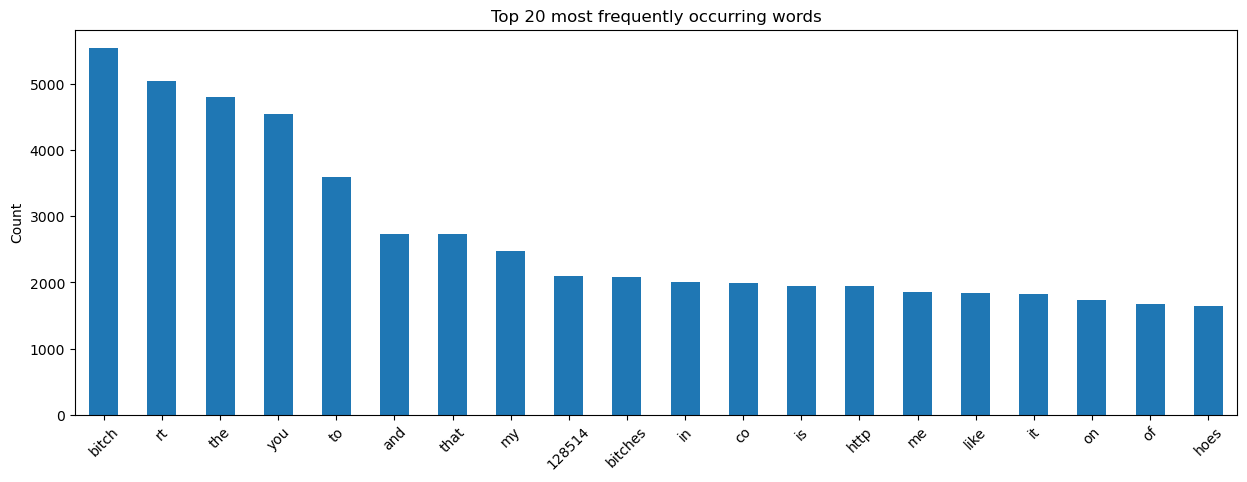

In [133]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Fitting a Classifier <a class="anchor" id="classifier"></a>

We will use a Logistic Regression model to predict if a tweet is hate speach, offensive language or neither.

In [134]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.9388701517706577
Test score: 0.8972979581855972


Let's look at the coefficients of our model:

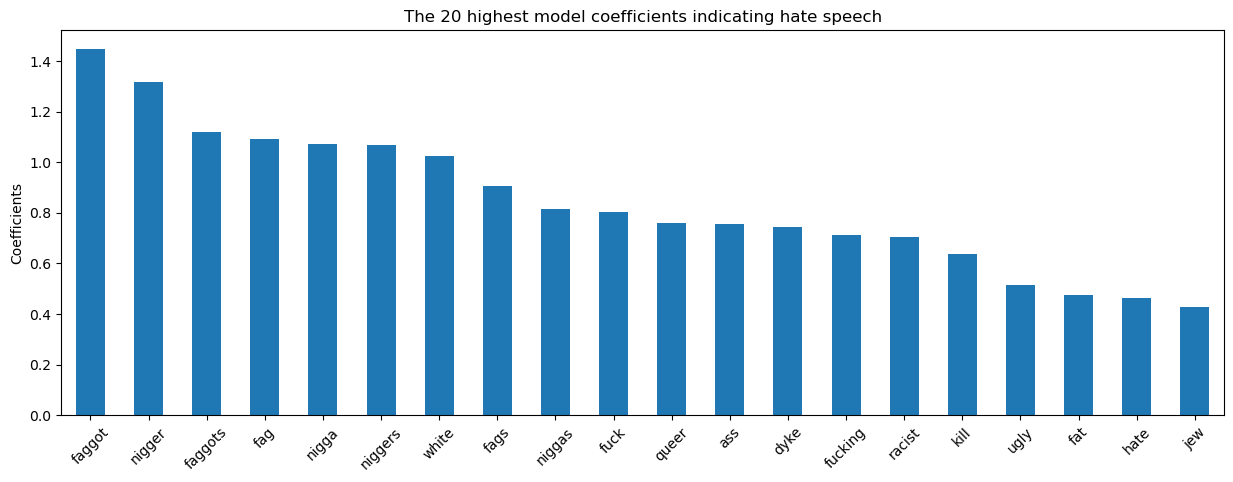

In [135]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating hate speech")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

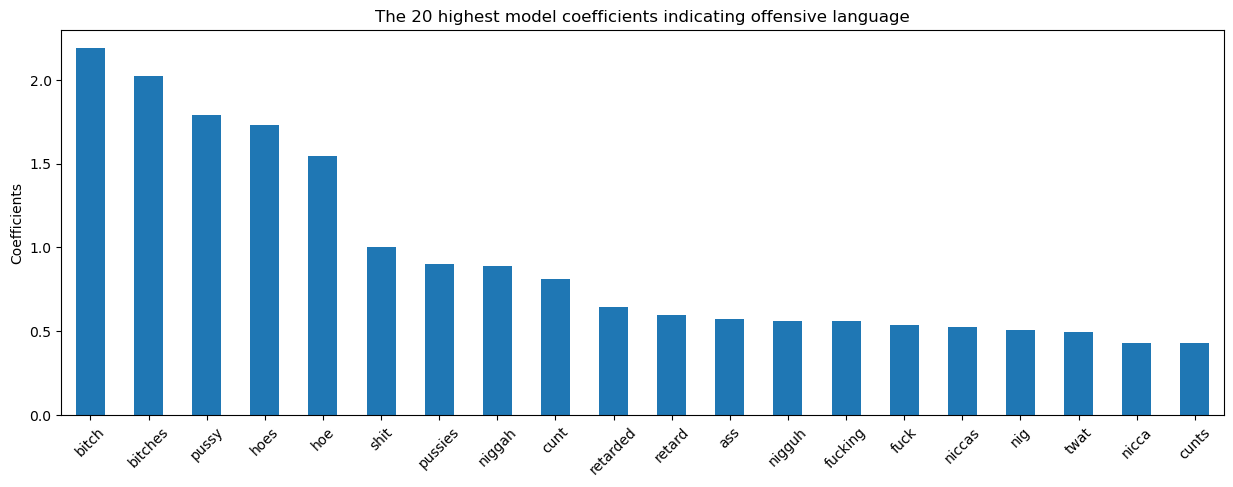

In [136]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[1]},
    index=bagofwords.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating offensive language")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

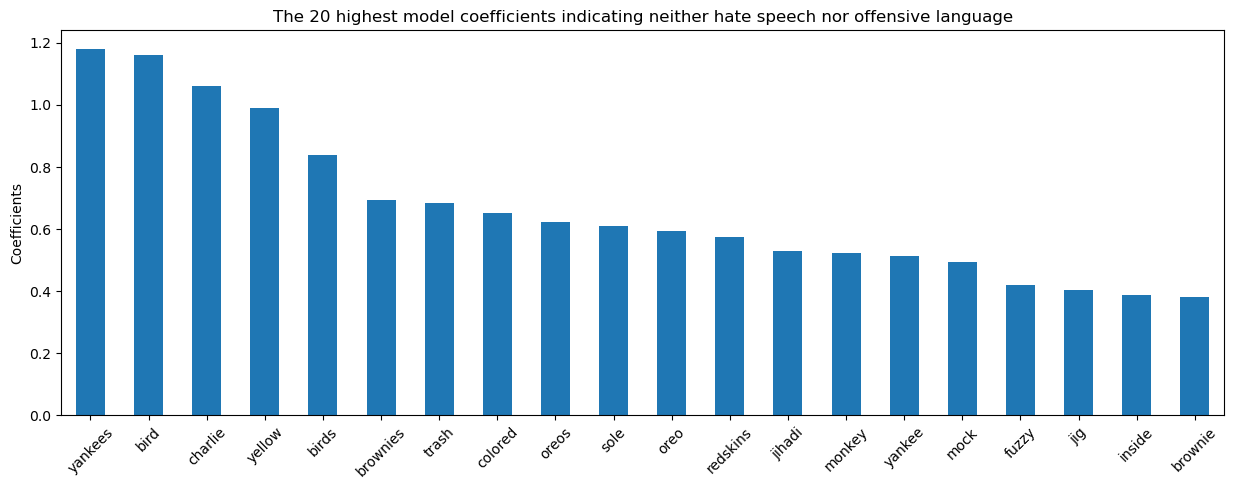

In [137]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[2]},
    index=bagofwords.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating neither hate speech nor offensive language")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

Let's compare KNN to our Logistic Regression model above to see which model performs better.

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
# Instantiate the model
knn = KNeighborsClassifier()

# Fit
knn.fit(X_train_transformed, y_train)

print(f'train score: {knn.score(X_train_transformed, y_train)}')
print(f'test score: {knn.score(X_test_transformed, y_test)}')

train score: 0.8733437725849192
test score: 0.8287076659738354


## Conclusion <a class="anchor" id="con"></a>

The Logistic Regression model gives us higher train and test scores.